# Can We Predict the Weather Accurately Using Neural Networks?


<b><u>Abstract:</u></b><br>
Predicting the weather has been of importance to humans for thousands of years; it dictates how we make a multitude of decisions, varying from choosing what to wear in the morning to knowing when is a good time to plant crops. Currently, our weather predictions lie in the hands of meteorologists who use complicated models and algorithms based on concepts from physics, chemistry and mathematics in order to make their predictions. While the quality of these predictions has steadily improved over the years, the mathematically chaotic nature that weather patterns tend to follow make predictions extremely difficult, especially over long periods of time. Improving the accuracy of these predictions using machine learning models could be the next step towards advanced weather predictions. The work presented here shows that by using a model consisting of a combination of different nerual networks, reasonable predictions can be made. The quality of these predictions is perhaps hinting at the possibility of more accuracte models that could be developed in the near future. 

<table>
    <tr>
        <td>
            <figure>
                <img width=300 height=300 src="images/neural_network_brain.png">
            </figure>
        </td>
        <td>
            <figure>     
                <img src="images/weather_forcast.jpg">
           </figure>
        </td>
    </tr>
</table>



## Section 0: Imports, Functions, and Global Variables
As its name suggests, this section contains all of the imports, functions, and global variable declations that are used in order to complete this project. All of these items were included here to enhance readability of later sections and provide a single place where they can be referenced, if necessary. 

### 0.1: Imports
Below is a list of all imports that were used in order to complete this project, organized by category. 

In [1]:
# Data manipulation imports
import pandas as pd
import numpy as np
np.random.seed(91993) 

In [2]:
# Plotting imports 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Mathematical tools imports
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.integrate import odeint

In [4]:
# Data Preprocessing Imports
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [5]:
# Machine Learning Algorithm Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [6]:
# Model selection (hyperparameter tuning) imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [7]:
# Neural Network Imports (Keras and tensorflow)
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

### 0.2: Functions
Below is a list of all functions that were used in order to complete this project, listed in the order in which they are first used. 

In [8]:
def make_classes(rainfall, snowfall):
    '''Creates target variable to predict by generating the following three classes from 
    rainfall and snowfall measurements:
    
    0 --> Clear weather, no rain or snow.
    1 --> Rainy weather.
    2 --> Snowy weather. 
    '''
    if snowfall == 0:
        if rainfall == 0:
            return 0
        else:
            return 1
    else:
        return 2
    
def prepare_data(df, num_hours, do_std_scaler=False, do_min_max_scaler=False, do_pca=-1, do_smote=False):
    '''Prepares data analysis by various machine leanring algorithms or neural networks. Returns
    training, validation and testing sets for both the predictor and target variables. A description of 
    each argument is given below:
    
    df --> The dataframe containing the data. 
    
    num_hours --> The value in the num_hours column used to filter out the desired data. 
    
    do_std_scaler --> If True, creates an instance of the StandardScaler class, fits it to the 
    X training data, and then transforms the X training, validation, and testing sets. 
    
    do_min_max_scaler --> If True, creates an instance of the MinMaxScaler class, fits it to the 
    X training data, and then transforms the X training, validation, and testing sets.
    
    do_PCA --> If 0, creates an instance of the PCA class with no set value for the n_components
    of the PCA class. If > 0, creates an instance of the PCA class with n_components = do_pca. In both cases,
    the function fits it to the X training data, and then transforms the X training, validation, and testing sets. 
    
    do_SMOTE --> If True, creates an instance of the SMOTE class, fits it to the X and y training data, 
    and resamples both training sets. 
    
    X_test and y_test are created using the df_test dataset created in Section 2. 
    '''
    y = df[df['num_hours']==num_hours]['class'].values
    X = df[df['num_hours']==num_hours].drop(columns=cols_to_drop).values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    X_test = df_test[df_test['num_hours']==num_hours].drop(columns=cols_to_drop).values
    y_test = df_test[df_test['num_hours']==num_hours]['class'].values
    
    if do_std_scaler == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    if do_min_max_scaler == True:
        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
    if do_pca > -1:
        if do_pca == 0:
            pca = PCA()
        elif do_pca > 0:
            pca = PCA(n_components = do_pca)
        X_train = pca.fit_transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)
    if do_smote == True:
        sm = SMOTE(random_state=rs)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
def give_metrics(y_true, y_pred, num_classes, variables=False):
    assert(num_classes > 0), 'Number of classes cannot be 0 or less!'
    assert (len(y_true) == len(y_pred)), "Array length does not match!"
    
    con_mat = confusion_matrix(y_true, y_pred)
    TP = np.diag(con_mat)
    FP = con_mat.sum(axis=0) - np.diag(con_mat)  
    FN = con_mat.sum(axis=1) - np.diag(con_mat)
    TN = con_mat.sum() - (FP + FN + TP)
    
    recalls = TP/(TP+FN)
    precisions = TP/(TP+FP)
    F1_scores = 2 * ((recalls*precisions)/(precisions+recalls))
    acc = np.sum(TP)/len(y_true)

#   recall_micro_avg = np.sum(TP) / (np.sum(TP) + np.sum(FN))
    recall_macro_avg = np.sum(recalls) / num_classes
#   precision_micro_avg = np.sum(TP) / (np.sum(TP) + np.sum(FP))
    precision_macro_avg = np.sum(precisions) / num_classes
    F1_macro_avg = 2 * ((recall_macro_avg*precision_macro_avg)/(precision_macro_avg+recall_macro_avg))
    
    if variables == True:
        return acc, recall_macro_avg, precision_macro_avg, F1_macro_avg
    
    print('Performance Metrics: \n')
    print('Confusion Matrix:')
    print(con_mat)
    print('\n')

    for i in range(num_classes):
        print('Class %d:' %i)
        print('Recall: ', recalls[i])
        print('Precision: ', precisions[i])
        print('F1 Score:', F1_scores[i])
        print('\n')

    print('Overall Metrics:')
    print('Total Accuracy: ', acc)
    print('Average Recall (Macro): ', recall_macro_avg)
#   print('Average Recall (Micro): ', recall_micro_avg)
#   print('\n')
    print('Average Precision (Macro) :', precision_macro_avg)
    print('Average F1 Score (Macro): ', F1_macro_avg)
#   print('Average Precision (Micro) :', precision_micro_avg)
    
#Precision: Given all the predicted labels (for a given class X), how many instances were correctly predicted? 
#Recall: For all instances that should have a label X, how many of these were correctly captured?


#For imbalanced class problems:
#Use micro-averaging to weight your metric towards the largest one.
#Use macro-averaging to weight your metric towards the smallest one
    
def make_classes_extra(rainfall, snowfall):
    '''Same as the 'make_classes' function, but adds an additional two classes based on the 
    severity of rainfall and snowdfall. Classes are as follows: 
    
    0 --> Clear weather, no rain or snow.
    1 --> Rain less than 0.3mm in the hour. Considered light rainfall.
    2 --> Rain more than 0.3mm in the hour. Considered moderate to heavy rainfall.
    3 --> Snow less than 0.2cm in the hour. Considered light snowfall.
    4 --> Snow more than 0.2cm in the hour. Considered moderate to heavy snowfall.
    '''
    if snowfall ==  0:
        if rainfall == 0:
            return 0
        else:
            if rainfall <= 0.3:
                return 1
            else:
                return 2
    else:
        if snowfall < 0.2:
            return 3
        else: 
            return 4
    
def get_data_ready(dataset):
    y_undersample = dataset[dataset['num_hours']==0]['class'].values.reshape(-1,1)
    y_undersample_cat = to_categorical(dataset[dataset['num_hours']==0]['class'])
    X_undersample = dataset[dataset['num_hours']==0][['temperature', 'humidity', 'mslp', \
                'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']].values

    X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample_cat, test_size=0.3, \
                                                        random_state=rs)

def give_class_names(class_num):
    '''Given the class number, return the name of the class.'''
    if class_num == 0:
        return 'Clear'
    elif class_num == 1:
        return 'Rain'
    else:
        return 'Snow'
    
def make_weather_prediction(measurements):
    '''Given a set of initial weather conditions, make a prediction as to whether it will
    rain, snow or be clean from 0-12 hours into the future. Each prediction is made using a 
    tuned neural network.
    '''
    prediction_0hr = np.argmax(model_0hr.predict(measurements), axis = 1)
    prediction_1hr = np.argmax(model_1hr.predict(measurements), axis = 1)
    prediction_2hr = np.argmax(model_2hr.predict(measurements), axis = 1)
    prediction_3hr = np.argmax(model_3hr.predict(measurements), axis = 1)
    prediction_4hr = np.argmax(model_4hr.predict(measurements), axis = 1)
    prediction_5hr = np.argmax(model_5hr.predict(measurements), axis = 1)
    prediction_6hr = np.argmax(model_6hr.predict(measurements), axis = 1)
    prediction_7hr = np.argmax(model_7hr.predict(measurements), axis = 1)
    prediction_8hr = np.argmax(model_8hr.predict(measurements), axis = 1)
    prediction_9hr = np.argmax(model_9hr.predict(measurements), axis = 1)
    prediction_10hr = np.argmax(model_10hr.predict(measurements), axis = 1)
    prediction_11hr = np.argmax(model_11hr.predict(measurements), axis = 1)
    prediction_12hr = np.argmax(model_12hr.predict(measurements), axis = 1)
    predictions = [prediction_0hr, prediction_1hr, prediction_2hr, prediction_3hr, \
                   prediction_4hr, prediction_5hr, prediction_6hr, prediction_7hr, \
                   prediction_8hr, prediction_9hr, prediction_10hr, prediction_11hr, \
                   prediction_12hr]
    tmp = {'predictions': predictions}
    predictions = pd.DataFrame({'predictions': predictions})
    predictions = predictions['predictions'].map(give_class_names)
    return predictions

### 0.3: Global Variables 
The cell below contains all global variables that were used in this project, in order to increase ease of reproducability. 

In [9]:
rs = 42 # The random_state used by all relevant functions and methods in this project. 
seed_num = 91993 # The seed number for random calculations carried out by the numpy package. 
np.random.seed(seed_num) 

## Section 1: Introduction
This sections contains all introductory material that is referenced in later sections of this project. 
### 1.1: How are Weather Predictions Made?
Weather predictions are something that all of us rely on every day. In fact, the first thing most people do before heading out the door is check their favorite weather app to determine what they should be wearing that day. While we are surrounding by weather predictions every day, it turns out that the models used to calculate these predictions are extemeley complex. While there are a multitude of different methods for doing this, they almost always rely on some implementation of the Navier-Stokes equations. These equations are the foundation of fluid dynamics, similar to how the Schrodinger equation is the foundation of quantum mechanics. While these equaitons are a great achievement of physics, the fact that they are intricate differential equations makes them difficult to solve. One version of the equations can be seen below, provided by NASA: 

<img width=700 height=700 src="images/navier_stokes_equations.gif"/>

While the equations do provide information about the temperature, pressure, momentum, and density of a moving fluid, there is a lot of computational work that needs to be done in order to solve them. <br>

In addition to the complex nature of the Navier Stokes equations, weather systems are also considered to be chaotic systems. Mathematically speaking, chaotic systems exhibit the following traits:

<ol>
    <li> The system is deterministic.</li>
    <li> The system is aperiodic.</li>
    <li> The system is extremely sensitive to intitial conditions.</li>
</ol>
        
The first trait might not make sense at first, as it might seem that a chaotic system is one that shouldn't be able to be perfectly described (deterministic). However, this is a common misconception: chaotic systems are entirely predictable, even for long periods of time, if you have the correct inputs. The real difficulty in modeling chaotic systems results from the third trait: chaotic systems are extremeley sensitive to initial conditions, meaning that two slightly different sets of inputs can result is drastically different predictions. This means that no matter how close a meterologist is to getting spot on atmospheric data, even the smallest discrepensy from the actual model can cause predictions to be way off in the near future. This is sometimes more colloquially referred to as the "butterfly effect." The following aside gives an example of a more simplistic chaotic system. 

### Aside: A Simple Chaotic System - The Lorenz System
One of the very first systems that is studied in any chaos theory class in known as the Lorenz system, first studied in detail by Edward Lorenz. This system relates to the project presented here, as he studied it in an attempt to better understand atmospheric convection. The system consists of three ordinary differential equations, which are shown below:
$$
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-x \\
\frac{dz}{dt} &= xy - \beta z
\end{align}
$$
In the equations above, $x$, $y$, and $z$ are cartesian coordinates, while $\sigma$, $\rho$, and $\beta$ are system parameters. This system is translated into python in the cell below:

In [10]:
def dx_dt(x, y):
    return sigma * (y - x)
def dy_dt(x, z):
    return x * (rho - z) - x
def dz_dt(x, y, z):
    return x * y - beta * z
def lorenz_system(coordinates, t):
    x, y, z = coordinates
    return dx_dt(x, y), dy_dt(x, z), dz_dt(x, y, z) 

It turns out that for most values of $\sigma$, $\rho$, and $\beta$, the Lorenz system is not chaotic at all. More specifically, if $\rho$ is small, the system almost always converges to one or two fixed points. However, once $\rho$ is larger than $\approx$ 24.74, chaotic behavior starts to occur. Feel free to change the intial conditions ($\sigma$, $\rho$, and $\beta$) in the cell below in order to see how the behavior of the lorenz system changes. Some suggestions are given below:
<ul>
    <li>$\rho$=10, $\sigma$=10, $\beta=\frac{8}{3}$: To see how the lorenz system behaves when it is not chaotic.</li>
    <li>$\rho$=28, $\sigma$=10, $\beta=\frac{8}{3}$: To see how the lorenz system behaves when it is not chaotic.</li>
    <li>$\rho$=28.1, $\sigma$=10, $\beta=\frac{8}{3}$: To see how a small change to a chaotic system produces an entirely different result.</li>
</ul>

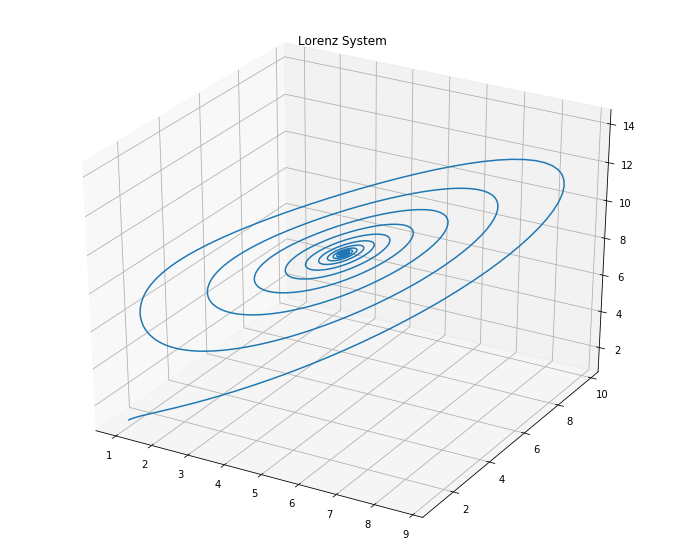

In [11]:
# Try changing these three variables
rho = 10.0
sigma = 10.0
beta = 8.0 / 3.0

# Do not change these...
t_i = 0
t_f = 20
t_step = 0.01
t = np.arange(t_i, t_f, t_step)
initial_xyz = [1.0, 1.0, 1.0]

def plot_lorenz(initial_xyz, t):
    positions = odeint(lorenz_system, initial_xyz, t)
    plt.axes(projection='3d')
    plt.title('Lorenz System')
    plt.plot(positions[:,0], positions[:,1], positions[:,2])
    
plt.figure(figsize=(12,10))
plot_lorenz(initial_xyz, t)

In case its too hard to make out the difference, the cell below shows the Lorenz system when $\rho$=28.0, $\sigma$=10.0, $\beta=\frac{8}{3}$, and when $\rho$=28.1, $\sigma$=10.0, $\beta=\frac{8}{3}$.

<table>
    <tr>
        <td>
            <figure>
                <img src="images/lorenz1.png">
                <figcaption><center>Initial Conditions: $\rho$=28.0, $\sigma$=10.0, and $\beta=\frac{8}{3}$.</center></figcaption>   
            </figure>
        </td>
        <td>
            <figure>     
                <img src="images/lorenz2.png">
                <figcaption><center>Initial Conditions: $\rho$=28.1, $\sigma$=10.0, and $\beta=\frac{8}{3}$.</center></figcaption>
           </figure>
        </td>
    </tr>
</table>


While the general shape of the graph is the same, further inspection reveals many differences by simply shifting $\rho$ by only 0.1 Another way of looking at this is to examine the final points of the lorenz system using each set of initial conditions. This is done in the cell below: 

In [12]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
positions1 = odeint(lorenz_system, initial_xyz, t)
rho = 28.1
sigma = 10.0
beta = 8.0 / 3.0
positions2 = odeint(lorenz_system, initial_xyz, t)
print('Last Positions of Lorenz system with rho = 28.0: ', positions1[-1])
print('Last Positions of Lorenz system with rho = 28.1: ', positions2[-1])
print(mean_squared_error(positions1, positions2))

Last Positions of Lorenz system with rho = 28.0:  [ 4.03961787  3.69586463 22.21668626]
Last Positions of Lorenz system with rho = 28.1:  [-8.60326073 -4.65002045 31.52552305]
82.00549649230874


We see that the final points from each system are completely different despite their initial conditions being nearly identical. Lastly, we can look at the mean squared error between the points from the two different Lorenz systems that were calculated:

In [13]:
print('Mean Squared Error between the two lorenz systems:', mean_squared_error(positions1, positions2))

Mean Squared Error between the two lorenz systems: 82.00549649230874


As is clear from the printout above, despite their shape looking similar, the points from the two different systems have an exorbitantly high mean squared error.

The point in showing this is to demonstrate that this sensitivity to inital conditions for chaotic systems can make correct predictions extremely difficult. The systems that dictate our weather patterns are also much more complex, further adding to the issue. In summary, this means is that if the atmospheric data used to make predictions is only slightly different from the actual value, the predictions might not be close to the weather that's actually on its way. This sensitivity also gets worse over time, which accounts for the fact that weather predictions made far in advance have a high probability of being incorrect. 

### 1.2: Neural Networks, a Possible Solution?

The previous subsection described how the current methods that are used in making weather predictions have some pretty serious flaws. The work performed here is meant to test whether or not predictive algorithms (specifically, neural networks) can be used to make predictions that are as good, or possibly even better than the physical models that are currently in use. <br><br>

Nueral networks seemed like a reliable choice to attempt to solve this problem, as they are capable of being able to determine complicated linear and non-linear relationships between a large number of input variables. Because the current method of weather forecasting is also complex, there already exists a large amount of high quality atmospheric data being used to make the predictions as accurate as possible. The work done in this project simply applies that same data to different machine learning models, with the most accurate possible neural network as the desired product. In general, these models performed reasonably well. 

### 1.3: The Data
The data used in this project comes from <a href="https://www.meteoblue.com/en/weather/week">meteoblue</a>, a meteorological service created at the University of Basel. They provide current, high quality meteorological data from places all over the world, but also give access to free historical weather data for Basel, Switzerland dating back to 1984. This was the data used for this project, and can be accessed <a href="https://www.meteoblue.com/en/products/historyplus/download/basel_switzerland_2661604">here.</a> A list of all the variables that are included in the dataset, along with their units and a brief description, is listed in the table below:

<table style="width:80%">
  <tr>
    <th>Measurement</th>
    <th>Units</th> 
    <th>Description</th>
  </tr>
  <tr>
    <td>Temperature</td>
    <td>$^{\circ}$F</td> 
    <td>The temperature recorded from 2 meters above the ground.</td>
  </tr>
  <tr>
    <td>Relative humidity</td>
    <td>%</td> 
    <td>the amount of water vapor present in air expressed as a percentage of the amount needed for saturation at the same temperature</td>
  </tr>
  <tr>
    <td>Pressure</td>
    <td>hPa</td> 
    <td>The mean sea level pressure (MSLP).</td>
  </tr>
  <tr>
    <td>Precipitation Amount</td>
    <td>mm</td> 
    <td>The total amount of precipitation that fell in hour measured according to a high resolution model.</td>
  </tr>
  <tr>
    <td>Precipitation amount (low resolution)</td>
    <td>mm</td> 
    <td>The total amount of precipitation that fell in hour measured according to a low resolution model.</td>
  </tr>
  <tr>
    <td>Snowfall amount (high resolution)</td>
    <td>cm</td> 
    <td>The total amount of snowdall that fell in the hour measured according to a high resolution model.</td>
  </tr>
  <tr>
    <td>Snowfall amount (low resolution)</td>
    <td>cm</td> 
    <td>The total amount of precipitation that fell in the hour measured according to a low resolution model.</td>
  </tr>
  <tr>
    <td>Total cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by a cloud of any type at any height in the sky.</td>
  </tr>
  <tr>
    <td>High cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at high elevation (5-13 km).</td>
  </tr>
  <tr>
    <td>Mid cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at medium elevation (2-7 km).</td>
  </tr>
  <tr>
    <td>Low cloud cover</td>
    <td>%</td> 
    <td>The fraction of the sky covered by clouds at low elevation ($<$2 km).</td>
  </tr>
  <tr>
    <td>Sunshine duration (minutes)</td>
    <td>Minutes</td> 
    <td>The number of minutes in each hour when there was no cloud cover.</td>
  </tr>
  <tr>
    <td>Solar radiation</td>
    <td>W/m$^2$</td> 
    <td>The power emitted by the sun for every sqaure meter. Also referred to as 'irradiance'.</td>
  </tr>
  <tr>
    <td>Wind speed (10m)</td>
    <td>mph</td> 
    <td>The wind speed measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind direction (10m)</td>
    <td>$^\circ$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind speed (80m)</td>
    <td>mph</td> 
    <td>The wind speed measured from 80m above the ground.</td>
  </tr>
  <tr>
    <td>Wind direction (80m)</td>
    <td>$^{\circ}$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured from 10m above the ground.</td>
  </tr>
  <tr>
    <td>Wind speed (900hPa)</td>
    <td>mph</td> 
    <td>The wind speed measured at an air pressure of 900hPa.</td>
  </tr>
  <tr>
    <td>Wind direction (900hPa)</td>
    <td>$^{\circ}$ (0$^{\circ}$ is North)</td> 
    <td>The wind direction measured at an air pressure of 900hPa.</td>
  </tr>
  <tr>
    <td>Wind gusts (10m)</td>
    <td>mph</td> 
    <td>Highest wind speed that was measured in an hour from 10m above the ground. </td>
  </tr>
</table>

## Section 2: Data Cleaning
This section includes all data cleaning steps that were taken in order to prepare the dataset for further analysis. Luckily, not much extensive cleaning was required, given the high quality of data provided by <a href="https://www.meteoblue.com/en/weather/week">meteoblue</a>. The raw data can be accessed from the following <a href="basel_weather_7-1-09_to_7-1-19.csv">file</a>, and contains ten years of hourly atmospheric data from Basel, Switzerland dating from 7/1/09 to 7/1/19.

In [14]:
# Read in dataset and convert into a pandas dataframe. 
df = pd.read_csv('basel_weather_1-1-09_to_12-31-18.csv', sep=';', header=10)
df.head()

,Year,Month,Day,Hour,Minute,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Mean Sea Level Pressure [MSL],Total Precipitation (high resolution) [sfc],Total Precipitation (low resolution) [sfc],...,Low Cloud Cover [low cld lay],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Speed [80 m above gnd],Wind Direction [80 m above gnd],Wind Speed [900 mb],Wind Direction [900 mb],Wind Gust [sfc]
0,2009,1,1,0,0,34.30,88.0,1026.3,0.0,0.1,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,0,34.75,87.0,1026.4,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,0,32.97,90.0,1026.5,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,0,31.19,89.0,1026.9,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,0,36.66,96.0,1026.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


In [15]:
# Print out dataframe information. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 25 columns):
Year                                            87648 non-null int64
Month                                           87648 non-null int64
Day                                             87648 non-null int64
Hour                                            87648 non-null int64
Minute                                          87648 non-null int64
Temperature  [2 m above gnd]                    87648 non-null float64
Relative Humidity  [2 m above gnd]              87648 non-null float64
Mean Sea Level Pressure  [MSL]                  87648 non-null float64
Total Precipitation (high resolution)  [sfc]    87648 non-null float64
Total Precipitation (low resolution)  [sfc]     87648 non-null float64
Snowfall Amount (high resolution)  [sfc]        87648 non-null float64
Snowfall Amount (low resolution)  [sfc]         87648 non-null float64
Total Cloud Cover  [sfc]                        8

As can be seen in the prinout above, all variables that are listed in Section 1.3 are present, and none of the columns contain any null values. 

In [16]:
df['Minute'].value_counts()

0    87648
Name: Minute, dtype: int64

Since all measurements are taken at the top of every hour, the minute column provides no additional information (it is always zero) and can be dropped. This is clear from the `.value_counts()` printout above.

In [17]:
# Drop minute column.
df = df.drop(columns=['Minute'])
df.head()

,Year,Month,Day,Hour,Temperature [2 m above gnd],Relative Humidity [2 m above gnd],Mean Sea Level Pressure [MSL],Total Precipitation (high resolution) [sfc],Total Precipitation (low resolution) [sfc],Snowfall Amount (high resolution) [sfc],...,Low Cloud Cover [low cld lay],Sunshine Duration [sfc],Shortwave Radiation [sfc],Wind Speed [10 m above gnd],Wind Direction [10 m above gnd],Wind Speed [80 m above gnd],Wind Direction [80 m above gnd],Wind Speed [900 mb],Wind Direction [900 mb],Wind Gust [sfc]
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.1,0.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


In [18]:
# Rename the columns so they are clearer and more concise. 
column_names = ['year', 'month', 'day', 'hour', 'temperature', 'humidity', 'mslp', 'rainfall_hr', 'rainfall_lr', \
                'snowfall_hr', 'snowfall_lr', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
df.columns = column_names
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,rainfall_lr,snowfall_hr,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.1,0.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,0.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,0.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,0.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,0.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


Note that both the rainfall and snowfall measurements come in both high resoluton and low resolution options. In order to choose between the two, a direct inquiry to meteoblue was made. According to one of their representatives:

<b>"For precipitation and snowfall amount, we (usually) offer two different datasets:
<ol>
    <li>The low resolution data, available since 1985, comes from our global NEMS30 (30km resolution) model, and is available for every point on earth.</li>
    <li>The high resolution data depends on the location you are collecting the data for. For all regions where we run a local domain of our model, data with a higher resolution is available. On the following <a href="https://content.meteoblue.com/en/specifications/data-sources/weather-simulation-data/meteoblue-models"/>page</a>, you can see which local domain is available for which region and when that it was implemented.</li>
</ol>
If there is no high resolution domain available, both options will provide the data from NEMS30.
We offer these two datasets for precipitation because, opposite to other variables such as temperature, it is not possible to merge two different datasets so that there is no inconsistency remaining."</b>

The following chart can be obtained by going to the page referenced in the quote above:
<img width=700 height=700 src="images/meteoblue_data_types.png"/>
Based on this chart, we see that in 2008 meteoblue starting using the high resolution NMM12 model in order to measure rainfall and snowfall amounts in Europe (and thus, Switzerland). Since all the data used in this project is from 2009 or later, using the high resolution data seemed like the better choice. The cell below removes the low resolution data so that only the high resolution data remains.



In [19]:
# Use only the high resolution rainfall and snowfall measurements.
df = df.drop(columns = ['rainfall_lr', 'snowfall_lr'])
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,0,34.30,88.0,1026.3,0.0,0.0,8.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,1,34.75,87.0,1026.4,0.0,0.0,100.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,2,32.97,90.0,1026.5,0.0,0.0,3.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,3,31.19,89.0,1026.9,0.0,0.0,4.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,4,36.66,96.0,1026.0,0.0,0.0,100.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


The times that were provided in the dataset were given in Greenwich mean time (GMT), which is two hours behind the time in Basel, Switzerland. The following cell accounts for this difference by shifting the time two hours forward. 

In [20]:
# Account for time difference between GMT and time in Basel.
df['hour'] = df['hour'].map(lambda x: (x + 2) % 24)
for i, row in df.iterrows():
      if row.hour == 0 or row.hour == 1:
        df.at[i,'day'] += 1
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,low_cloud_cover,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust
0,2009,1,1,2,34.30,88.0,1026.3,0.0,0.0,8.0,...,8.0,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24
1,2009,1,1,3,34.75,87.0,1026.4,0.0,0.0,100.0,...,100.0,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90
2,2009,1,1,4,32.97,90.0,1026.5,0.0,0.0,3.0,...,3.0,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43
3,2009,1,1,5,31.19,89.0,1026.9,0.0,0.0,4.0,...,4.0,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54
4,2009,1,1,6,36.66,96.0,1026.0,0.0,0.0,100.0,...,100.0,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57


The <b>rainfall_hr</b> and <b>snowfall_hr</b> columns give the respective snowfall that occured in the hour after other measurements like temperature and humidity were taken. In the cell below, the values in these columns are used in conjunction with the `make_classes()` function in order to create a new column, called <b>class_0hr</b>, that will act as the target variable in future predictive modeling. The three classes are listed below (which can also be found in the DOCSTRING of the `make_classes()` function):
<table style="width:30%">
  <tr>
    <th>Class</th> 
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Clear Weather - no rain or snow.</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Rainy weather - It rained (but did not snow) any amount in the hour.</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Snowy weather - It snowed any amount in the hour.</td>
  </tr>
</table>


In [21]:
# Create classes for the rows.
df['class_0hr'] = df.apply(lambda x: make_classes(x.rainfall_hr, x.snowfall_hr), axis = 1)
df.head()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,sunshine_duration,shortwave_radiation,wind_speed_10m,wind_dir_10m,wind_speed_80m,wind_dir_80m,wind_speed_900mb,wind_dir_900mb,wind_gust,class_0hr
0,2009,1,1,2,34.30,88.0,1026.3,0.0,0.0,8.0,...,-999.0,0.0,10.98,266.50,15.68,266.73,16.45,262.97,19.24,0
1,2009,1,1,3,34.75,87.0,1026.4,0.0,0.0,100.0,...,0.0,0.0,11.81,260.18,15.51,264.21,14.38,285.33,17.90,0
2,2009,1,1,4,32.97,90.0,1026.5,0.0,0.0,3.0,...,0.0,0.0,10.89,260.54,15.07,264.04,11.74,277.67,15.43,0
3,2009,1,1,5,31.19,89.0,1026.9,0.0,0.0,4.0,...,0.0,0.0,12.25,260.54,17.69,260.54,10.02,293.70,14.54,0
4,2009,1,1,6,36.66,96.0,1026.0,0.0,0.0,100.0,...,0.0,0.0,1.63,344.05,1.58,8.13,3.83,6.71,1.57,0


The dataframe seen above now incldues classes for each of its rows. However, in that current state any model that uses it would only be able to make weather predictions within 1 hour of the other quantities being measured. The cell below adds an additional 12 columns that allow any model to make predictions up to 12 hours in the future. In other words, it changes the dataframe so that each row includes if it was clear, rainy, snowy for 0-12 hours in the future.

In [22]:
for i in range(1, 13):
    col_name = 'class_' + str(i) + 'hr'
    shiftnum = i * -1
    df[col_name] = df['class_0hr'].shift(shiftnum)
    df = df.dropna()
    df[col_name] = df[col_name].astype(int)


df.tail()

,year,month,day,hour,temperature,humidity,mslp,rainfall_hr,snowfall_hr,total_cloud_cover,...,class_3hr,class_4hr,class_5hr,class_6hr,class_7hr,class_8hr,class_9hr,class_10hr,class_11hr,class_12hr
87565,2018,12,28,15,44.47,51.0,1028.8,0.0,0.0,47.0,...,0,0,0,0,0,0,0,0,0,0
87566,2018,12,28,16,44.73,51.0,1028.4,0.0,0.0,50.0,...,0,0,0,0,0,0,0,0,0,0
87567,2018,12,28,17,43.72,55.0,1028.8,0.0,0.0,35.0,...,0,0,0,0,0,0,0,0,0,0
87568,2018,12,28,18,41.70,60.0,1029.3,0.0,0.0,14.0,...,0,0,0,0,0,0,0,0,0,0
87569,2018,12,28,19,40.15,63.0,1029.8,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87570 entries, 0 to 87569
Data columns (total 35 columns):
year                   87570 non-null int64
month                  87570 non-null int64
day                    87570 non-null int64
hour                   87570 non-null int64
temperature            87570 non-null float64
humidity               87570 non-null float64
mslp                   87570 non-null float64
rainfall_hr            87570 non-null float64
snowfall_hr            87570 non-null float64
total_cloud_cover      87570 non-null float64
high_cloud_cover       87570 non-null float64
medium_cloud_cover     87570 non-null float64
low_cloud_cover        87570 non-null float64
sunshine_duration      87570 non-null float64
shortwave_radiation    87570 non-null float64
wind_speed_10m         87570 non-null float64
wind_dir_10m           87570 non-null float64
wind_speed_80m         87570 non-null float64
wind_dir_80m           87570 non-null float64
wind_speed_900mb       87

In [24]:
df_list = []
for i in range(0, 13):
    col_name = 'class_' + str(i) + 'hr'
    cols = ['year', 'month', 'day', 'hour', 'temperature', 'humidity', 'mslp', 'rainfall_hr', \
            'snowfall_hr', 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
            'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
            'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust', col_name]
    tmp_df = df[cols]
    tmp_df = tmp_df.rename(index=str, columns={col_name: 'class'})
    tmp_df['num_hours'] = i
    df_list.append(tmp_df)

df = pd.concat(df_list).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138410 entries, 0 to 1138409
Data columns (total 24 columns):
year                   1138410 non-null int64
month                  1138410 non-null int64
day                    1138410 non-null int64
hour                   1138410 non-null int64
temperature            1138410 non-null float64
humidity               1138410 non-null float64
mslp                   1138410 non-null float64
rainfall_hr            1138410 non-null float64
snowfall_hr            1138410 non-null float64
total_cloud_cover      1138410 non-null float64
high_cloud_cover       1138410 non-null float64
medium_cloud_cover     1138410 non-null float64
low_cloud_cover        1138410 non-null float64
sunshine_duration      1138410 non-null float64
shortwave_radiation    1138410 non-null float64
wind_speed_10m         1138410 non-null float64
wind_dir_10m           1138410 non-null float64
wind_speed_80m         1138410 non-null float64
wind_dir_80m           1138410 

In [25]:
df['num_hours'].value_counts()

12    87570
11    87570
10    87570
9     87570
8     87570
7     87570
6     87570
5     87570
4     87570
3     87570
2     87570
1     87570
0     87570
Name: num_hours, dtype: int64

In [26]:
df_test = df.sample(113841, random_state=42)
df = df.drop(df_test.index)
df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024569 entries, 0 to 1024568
Data columns (total 24 columns):
year                   1024569 non-null int64
month                  1024569 non-null int64
day                    1024569 non-null int64
hour                   1024569 non-null int64
temperature            1024569 non-null float64
humidity               1024569 non-null float64
mslp                   1024569 non-null float64
rainfall_hr            1024569 non-null float64
snowfall_hr            1024569 non-null float64
total_cloud_cover      1024569 non-null float64
high_cloud_cover       1024569 non-null float64
medium_cloud_cover     1024569 non-null float64
low_cloud_cover        1024569 non-null float64
sunshine_duration      1024569 non-null float64
shortwave_radiation    1024569 non-null float64
wind_speed_10m         1024569 non-null float64
wind_dir_10m           1024569 non-null float64
wind_speed_80m         1024569 non-null float64
wind_dir_80m           1024569 

From the `.info()` printout above, we now see that each row contains a class that gives the type of weather for 0, 1, 2, all the way up to 12 hours into the future. More specifically, <b>class_0hr</b> says whether it was clear, rainy or snowy between 0-1 hours of the measurements being taken, <b>class_1hr</b> says whther it was clear rainy or snowy between 1-2 hours of the measurements being taken, and so on. 

While there are no issues with bad or missing data, the cell below exposes another problem particular to this dataset:

Text(1.9, 12860, '13360')

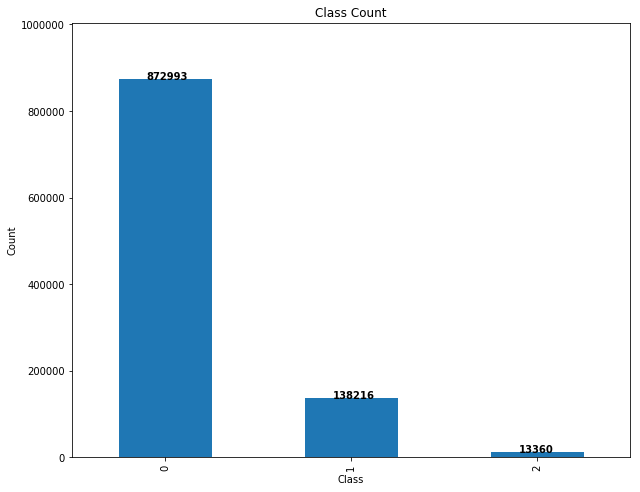

In [27]:
plt.figure(figsize=(10,8))
df['class'].value_counts().plot(kind='bar', title='Count - Class');
plt.title('Class Count')
plt.xlabel('Class');
plt.ylabel('Count');

count_class_0, count_class_1, count_class_2 = df['class'].value_counts()

plt.ylim([0, max([count_class_0, count_class_1, count_class_2])*1.15])
plt.text(-0.10, count_class_0-1000, count_class_0, fontweight='bold')
plt.text(0.90, count_class_1-1000, count_class_1, fontweight='bold')
plt.text(1.90, count_class_2-500, count_class_2, fontweight='bold')

Using the <b>class</b> column, it is clear according to the bar graph above that the vast majority of all rows represent hours in which the weather was clear. This can wreck havok on a model's ability to make accurate predicitons, as having discrepencies in the frequency of different classes can cause the model to be more or less likely to choose a certain class. 

One method that can be used to deal with this class discrepency is known as undersampling, in which the classes with higher frequency are randomly resampled so that they have the same frequency as the class with the lowest frequency. The next two cells implement this process so that the clear weather (0) and rainy weather (1) class have the same frequency as the snowy weather class (2). A new dataframe was created to hold the undersampled data, named ```df_us```.

In [28]:
df_class_0 = df[df['class'] == 0]
df_class_1 = df[df['class'] == 1]
df_class_2 = df[df['class'] == 2]

count_class_0, count_class_1, count_class_2 = df['class'].value_counts()

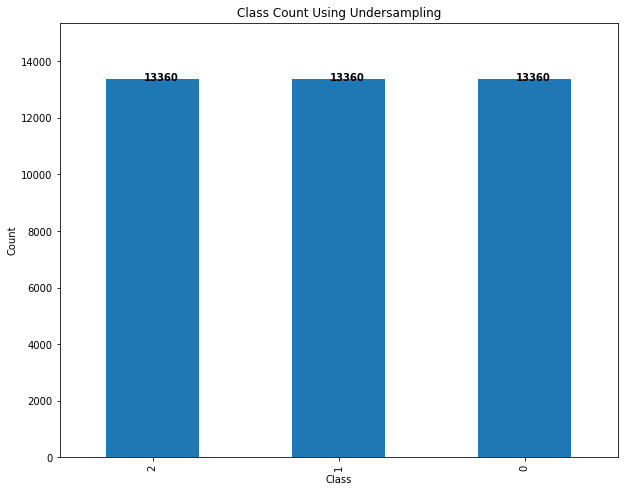

In [29]:
df_under_0 = df_class_0.sample(count_class_2, random_state=rs)
df_under_1 = df_class_1.sample(count_class_2, random_state=rs)
df_us = pd.concat([df_under_0, df_under_1, df_class_2], axis=0).reset_index(drop=True)

plt.figure(figsize=(10,8))
df_us['class'].value_counts().plot(kind='bar');
plt.title('Class Count Using Undersampling')
plt.xlabel('Class');
plt.ylabel('Count');

count0, count1, count2 = df_us['class'].value_counts()

plt.ylim([0, max([count0, count1, count2])*1.15])
plt.text(1.95, count0-25, count0, fontweight='bold')
plt.text(0.95, count1-25, count1, fontweight='bold')
plt.text(-0.05, count2-25, count2, fontweight='bold');

As we can see in the histrogram above, each class now has an equal number of instances. However, before proceeding, the code in the next cell makes sure that the class distribution is still relatively equal for each value of <b>num_hours</b>.

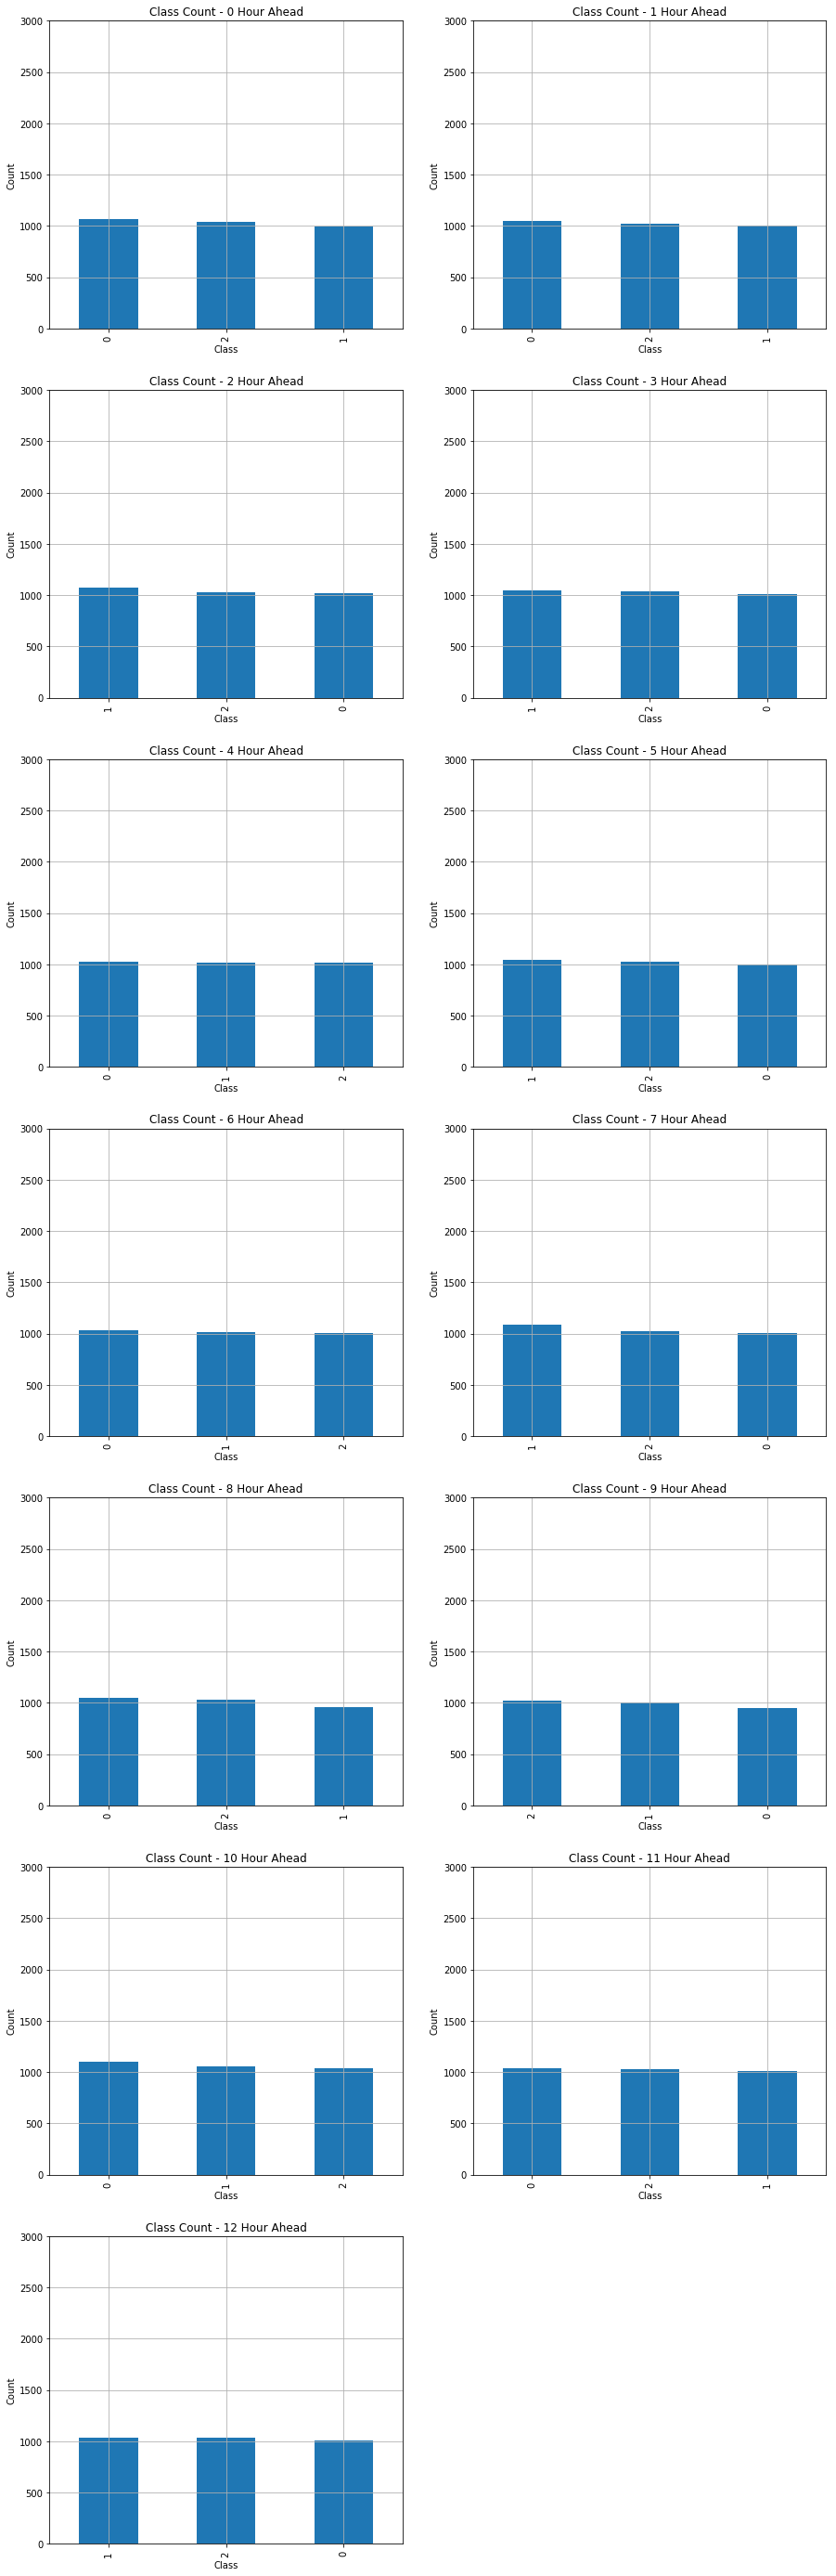

In [30]:
plt.figure(figsize=(15,50))
for i in range(0, 13):
    plt.subplot(7, 2, i+1)
    df_us[df_us['num_hours']==i]['class'].value_counts().plot(kind='bar')
    plt.title('Class Count - %d Hour Ahead' %i)
    plt.grid()
    plt.ylim([0,3000])
    plt.xlabel('Class')
    plt.ylabel('Count')

In [31]:
print('Class Value Counts:')
print(df_us['class'].value_counts())

print('\n')
print('Num Hours Value Counts:')
print(df_us['num_hours'].value_counts())

Class Value Counts:
2    13360
1    13360
0    13360
Name: class, dtype: int64


Num Hours Value Counts:
10    3197
2     3121
7     3118
0     3108
3     3101
12    3085
1     3079
11    3069
5     3065
4     3060
6     3049
8     3048
9     2980
Name: num_hours, dtype: int64


The histograms and the printout above make it clear that the data has been sufficiently undersampled. While the separation is not perfect for each value of <b>num_hours</b>, the class discrepencies are still very small and should not impact the results of any future predictive modeling or analysis. However, the downside of the undersampling technique is that it results in a huge loss of data (40,080 rows compared to 1,138,410 rows). Some of this data could be potentially very useful (especially in predicting the originally lower frequency classes) possibly resulting in bad generalizaiton to unseen data. For this reason, the next section compares results generated with the undersampled dataframe with results using sampling method, known as the Synthetic Minority Oversampling Technique (SMOTE).

The code below shows the ```.info()``` printout of the ```df_us``` dataframe.

In [32]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40080 entries, 0 to 40079
Data columns (total 24 columns):
year                   40080 non-null int64
month                  40080 non-null int64
day                    40080 non-null int64
hour                   40080 non-null int64
temperature            40080 non-null float64
humidity               40080 non-null float64
mslp                   40080 non-null float64
rainfall_hr            40080 non-null float64
snowfall_hr            40080 non-null float64
total_cloud_cover      40080 non-null float64
high_cloud_cover       40080 non-null float64
medium_cloud_cover     40080 non-null float64
low_cloud_cover        40080 non-null float64
sunshine_duration      40080 non-null float64
shortwave_radiation    40080 non-null float64
wind_speed_10m         40080 non-null float64
wind_dir_10m           40080 non-null float64
wind_speed_80m         40080 non-null float64
wind_dir_80m           40080 non-null float64
wind_speed_900mb       40

## Section 3: Exploratory Data Analysis (EDA)

To recap, the conclusion of the data cleaning section resulted in two dataframes:
  - ```df```: consists of 87,570 rows of atmospheric data along with their corresponding target variables for predictoins made 0-12 hours into the future (87,570 x 13 = 1,138,410 rows in total).
  - ```df_us```: An undersampled version of the ```df``` dataframe. Contains the same information as above but is resampled so that the frequency of each class matches the lowest frequency class (the snowy weather class). Contains 40,080 rows in total. 
  - ```df_test```: A test set containing a subset of approximately one year of data. Rows were selected randomly from the original ```df``` dataframe and then removed. Was created in order to see how any predictive algorithms perform on unseen data. 
  
  
  
The work done in this section is meant to explore the data in these dataframes in preparation for future modeling (specifically with neural networks). Various statistical methods and machine learning algorithms are used to gain a better understanding of the data and to determine how to best move forward in building more complex predictive models. 

### 3.1: Predictor Variable Histograms

The code in the cell below creates histograms for each of the predictor variables using the <b>df_us</b> dataframe.

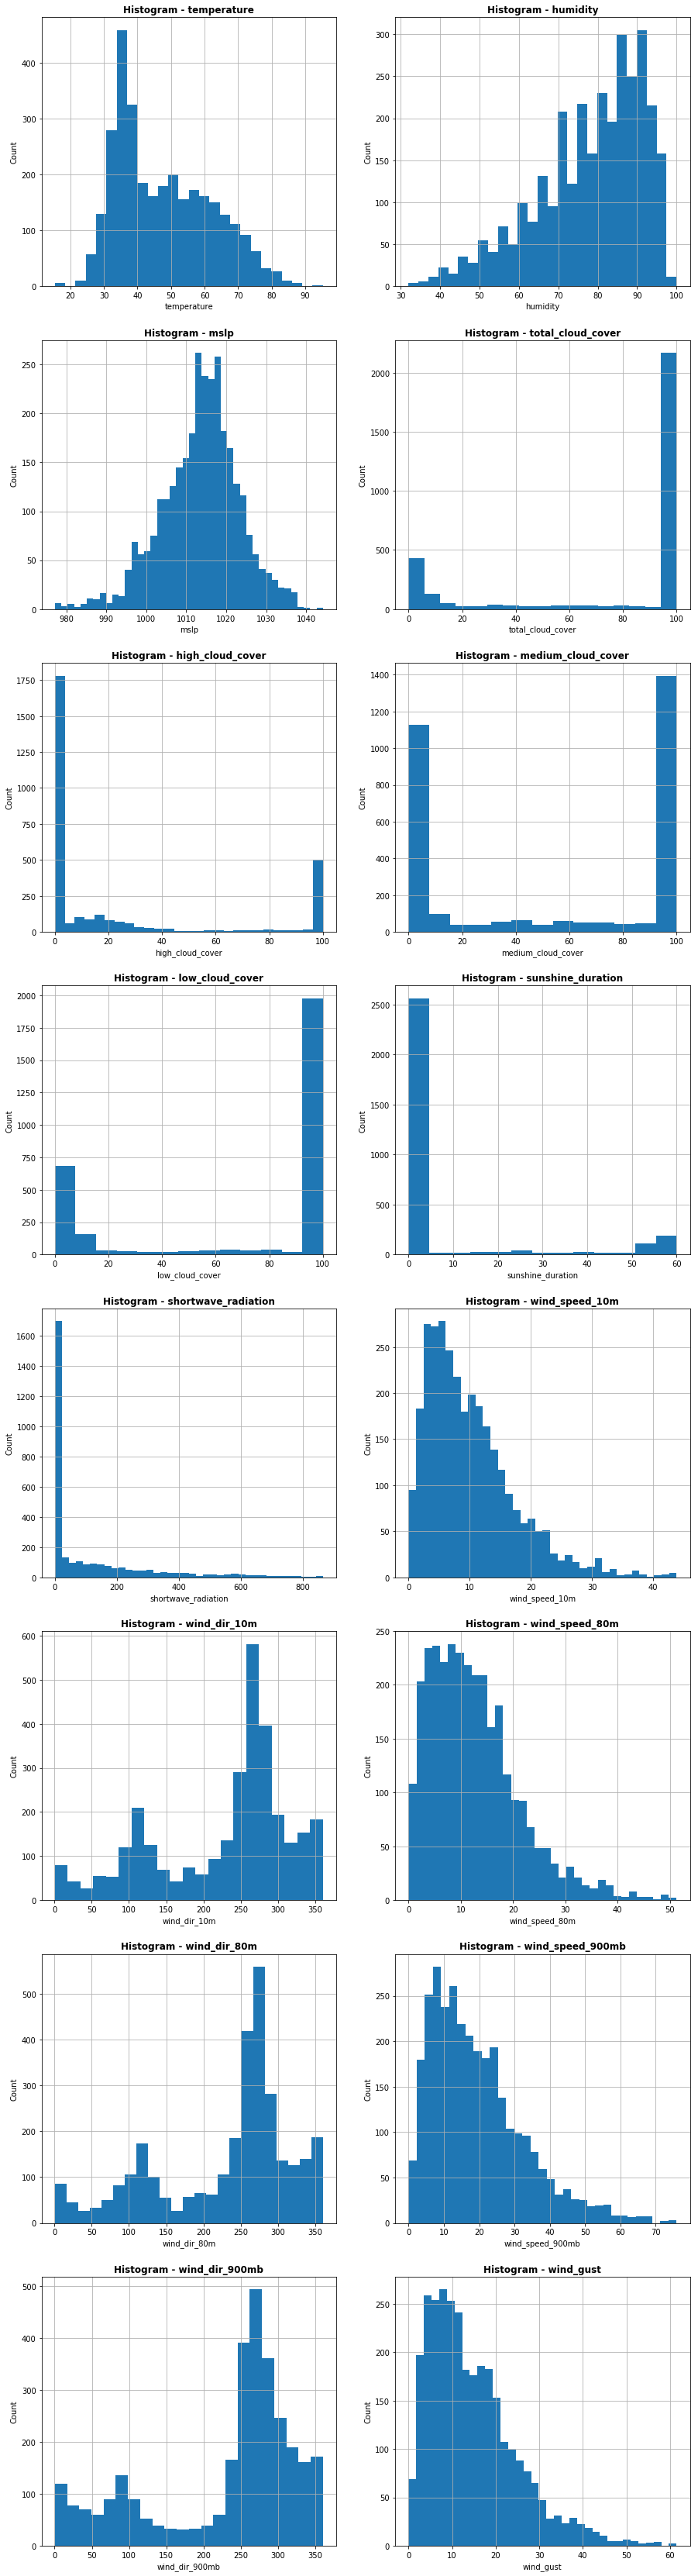

In [33]:
cols_for_hist = ['temperature', 'humidity', 'mslp', \
                 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                 'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                 'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
plt.figure(figsize=(15,60))
plotnum = 1
for column in cols_for_hist:
    plt.subplot(len(cols_for_hist)/2, 2, plotnum)
    plotnum += 1
    plt.hist(x=df_us[df_us['num_hours']==0][column], bins='auto')
    plt.grid()
    plt.title('Histogram - {}'.format(column), fontweight='bold')
    plt.ylabel('Count')
    plt.xlabel(column)

The histograms above reveal some interesting insights into the weather patterns that exist in Basel. For example, the temperature histogram reveals that the most common temperature in the city is in the mid 30s (quite chilly!). In addition, it almost never gets above 90 degrees. This makes sense given the fact that Basel exists at both a high latitude and elevation. Another observaiton is the fact that for all of the wind direction histograms, there is a high peak at around 270$^{\circ}$ and a smaller one around 100$^{\circ}$. Given that 0$^{\circ}$ is north, this corresponds to winds heading in the east and west direction. In other words, the strongest winds that blow through Basel will more often or not be in these two directions. 

### 3.2: Scatterplots of Predictor Variables vs. Target Variables

While the conclusions that can be drawn from these histograms are interesting, they provide no insight to how they relate to the target varible (whether or not it rained or snowed). The code below does this by creating scatter plots of each predictor variable as a function of the <b>rainfall_hr</b> and <b>snowfall_hr</b> variables using the ```df_us``` dataframe. 

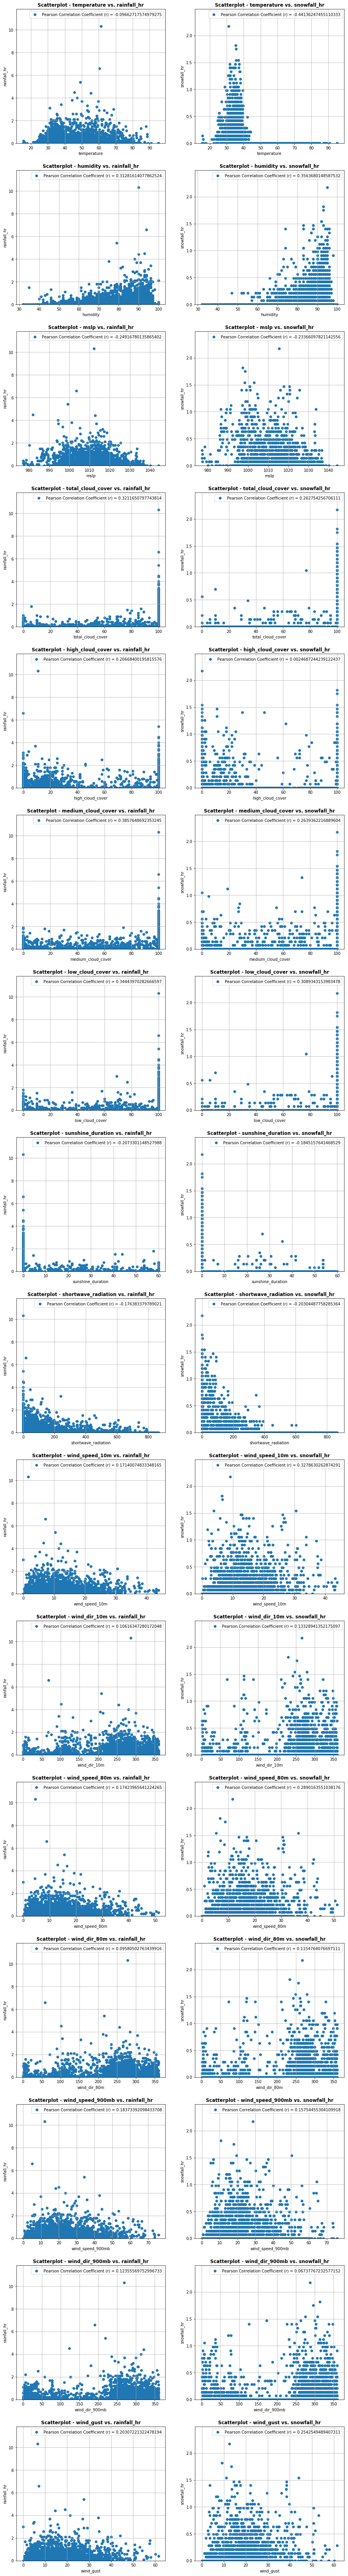

In [34]:
x_scatter_cols = ['temperature', 'humidity', 'mslp', \
                 'total_cloud_cover', 'high_cloud_cover', 'medium_cloud_cover', \
                 'low_cloud_cover', 'sunshine_duration', 'shortwave_radiation', 'wind_speed_10m', 'wind_dir_10m',\
                 'wind_speed_80m', 'wind_dir_80m', 'wind_speed_900mb', 'wind_dir_900mb', 'wind_gust']
y_scatter_cols = ['rainfall_hr', 'snowfall_hr']
plt.figure(figsize=(15,120))
plotnum = 1
for x_col in x_scatter_cols:
    for y_col in y_scatter_cols:
        plt.subplot(len(x_scatter_cols), len(y_scatter_cols), plotnum)
        plotnum +=1
        r = pearsonr(x=df_us[df_us['num_hours']==0][x_col], y=df_us[df_us['num_hours']==0][y_col])[0]
        plt.scatter(x=df_us[df_us['num_hours']==0][x_col], y=df_us[df_us['num_hours']==0][y_col], \
                   label='Pearson Correlation Coefficient (r) = {}'.format(r))
        plt.legend()
        plt.ylim([0, max(df_us[df_us['num_hours']==0][y_col])*1.15])
        plt.grid()
        plt.title('Scatterplot - %s vs. %s' %(x_col, y_col), fontweight='bold')
        plt.ylabel(y_col)
        plt.xlabel(x_col)

The scatterplots above also provide some interesting insights. For example, the highest value of $r$ resulted from correlating the <b>temperature</b> column with the <b>snowfall_hr</b> column. However, there was almost no correlation between <b>temperature</b> and <b>rainfall_hr</b>. This is likely due to the fact that it can rain in almost any temperature weather, but it can only snow if the temperature is below a certain value. However, in general the $r$ value never went much above 0.3, indicating slight, albeit existant, positive correlations between the predictor and target variables.  

### 3.3: K-Nearest-Neighbor Analysis
In order to establish a baseline for our neural network performance, the work done here presents an analysis using the much simpler k-nearest-neighbor algorithm. Given the fact that neural networks can build incredibly sophisticated models, it should be the case that they would outperform the results seen here. 

In addition to establishing a baseline, the work done in this section is the first time the validity of the undersampling method is tested. As mentioned at the end of Section 2, another sampling method known as the Synthetic Minority Over-Sampling Technique (SMOTE) is implemented here, and evidence is given that it results in  better performance compared to the undersampling method. 

The cell below prepares the data for analysis by the K nearest neighbor algorithm using the ```prepare_data()``` function (see Section 0.2). In short, the function returns training, validation, and testing sets for both the predictor and target variables. The training and validation sets are created from the dataframe given to the function as an argument, while the testing sets are created using the ```df_test``` dataframe constructed in Section 2. The <b>df_us</b> dataframe is used in this case and only rows for which the <b>num_hours</b> column equals 0.

In [35]:
cols_to_drop = ['year', 'month', 'day', 'hour', 'rainfall_hr', 'snowfall_hr', 'num_hours', 'class']
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0)

The cell below uses the training and validation sets created above to generate a graph of how the ```KNeighborsClassifier``` performs for different number of neighbors. The number of neighbors is modified by adjusting the ```n_neighbors``` argument of the ```KNeighborsClassifer``` class. 

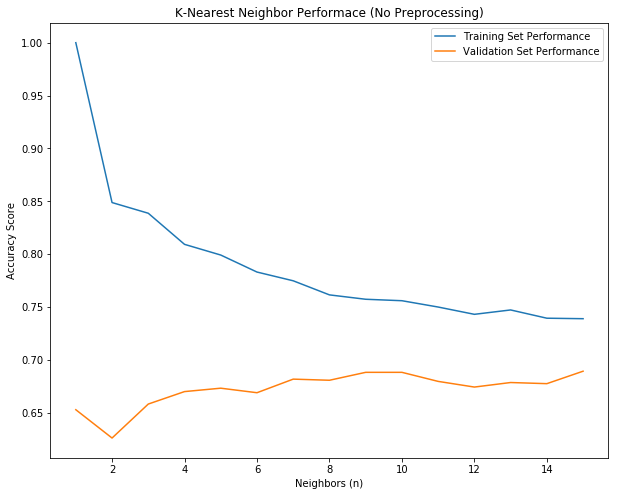

In [36]:
plt.figure(figsize = (10, 8))
max_n = 15
neighbors = np.arange(1, max_n+1)
train_scores = np.empty(len(neighbors))
val_scores = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn_tmp = KNeighborsClassifier(n_neighbors = k)
    knn_tmp.fit(X_train, y_train)
    train_scores[i] = knn_tmp.score(X_train, y_train)
    val_scores[i] = knn_tmp.score(X_val, y_val)

plt.plot(neighbors, train_scores, label = 'Training Set Performance')
plt.plot(neighbors, val_scores, label = 'Validation Set Performance')
plt.legend(loc='upper right')
plt.xlabel('Neighbors (n)')
plt.ylabel('Accuracy Score')
plt.title('K-Nearest Neighbor Performace (No Preprocessing)');

In [37]:
best_val_score = max(val_scores)
best_k = neighbors[np.where(val_scores == best_val_score)][0]
print('K-Nearest Neighbor Model Results (No Preprocessing):\n')
print('Best Validation Data Performance: %3.2f' %best_val_score)
print('Optimal Number of Neighbors: %d' % best_k)


K-Nearest Neighbor Model Results (No Preprocessing):

Best Validation Data Performance: 0.69
Optimal Number of Neighbors: 15


According to the graph and printout above, the ```KNeighborsClassifier``` had the highest validation set accuracy using 15 neighbors. However, this was without any preprocessing of the data. 

Because we are dealing with weather data, it is probably not incorrect to assume that many of the independent variables incldued in this analysis are correlated with themselves. For example, the graph below shows a scatterplot of <b>temperature</b> vs. <b>humidity</b>.

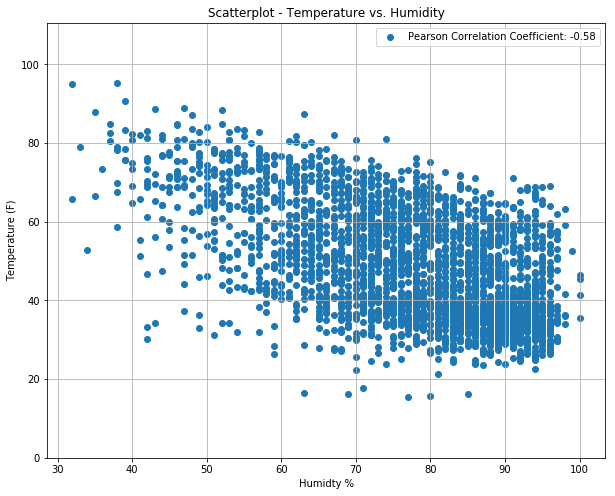

In [38]:
plt.figure(figsize = (10, 8))
r = pearsonr(df_us[df_us['num_hours']==0].humidity, df_us[df_us['num_hours']==0].temperature)[0]
plt.scatter(x=df_us[df_us['num_hours']==0].humidity, y=df_us[df_us['num_hours']==0].temperature, label =\
         'Pearson Correlation Coefficient: %2.2f' %r)
plt.title('Scatterplot - Temperature vs. Humidity')
pearsonr(df_us.humidity, df_us.temperature)[0]
plt.xlabel('Humidty %')
plt.legend()
plt.grid()
plt.ylim([0, max(df_us.temperature)*1.15])
plt.ylabel('Temperature (F)');
#pearsonr(df_undersample.humidity, df_undersample.temperature)[0]

Indeed we see that these two variables exhibit quite a strong negative correlation. These correlations most likely exist between a number of other combinations of independent variables. As such, the ```KNeighborsClassifier``` would most likely benefit from a principal component analysis, which removes these correlations. In addition, since the scales of the independent variables vary greatly, scaling the data using a ```StandardScaler``` would also likely improve performance. A principal component analysis using data scaled by a ```StandardScaler``` is done in the cell below. Once again, the data comes ```df_us``` dataframe for which <b>num_hours</b> equals 0. 

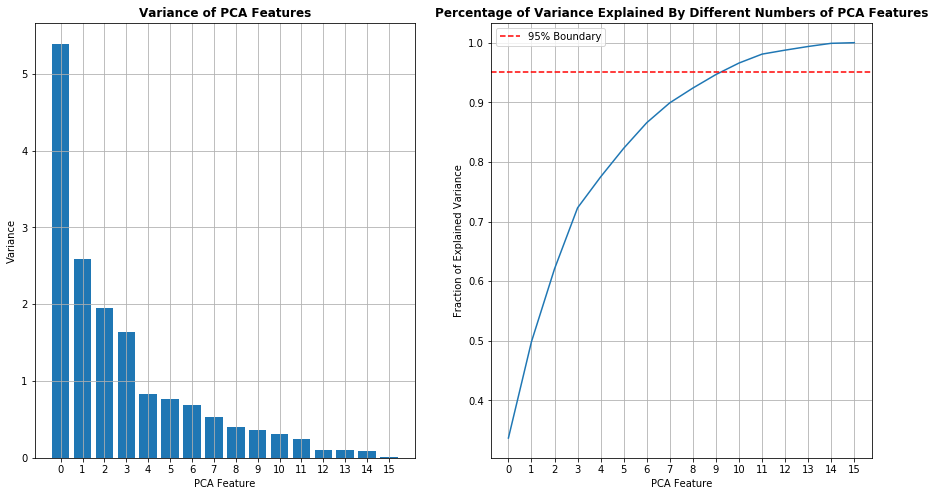

In [39]:
X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
y = df_us[df_us['num_hours']==0]['class'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X_train)

plt.figure(figsize=(15,8))
features = range(pca.n_components_)

plt.subplot(1, 2, 1)
plt.bar(features, pca.explained_variance_)
plt.title('Variance of PCA Features', fontweight='bold')
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.grid()
plt.xticks(features)


plt.subplot(1, 2, 2)
plt.plot(features, np.cumsum(pca.explained_variance_ratio_))
plt.title('Percentage of Variance Explained By Different Numbers of PCA Features', fontweight='bold')
plt.xlabel('PCA Feature')
plt.axhline(y=0.95, color = 'red', linestyle='--', label='95% Boundary')
plt.legend()
plt.ylabel('Fraction of Explained Variance')
plt.grid()
plt.xticks(features);

In [40]:
total = 0
best_n = 0
for percent in pca.explained_variance_ratio_:
    total += percent
    best_n += 1
    if total >= 0.95:
        break

print('%d PCA Features explain %2.2f %% of the variance.' %(best_n, total*100))

11 PCA Features explain 96.59 % of the variance.


According to the graphs and printout above, we see that 11 pca features are enough to explain more than 95% of the variance seen in the predictor variables. As such, this should be more than adaquate to help improve the performance of the ```KNeighborsClassifier```. The cells below show how the classifier's performance change using different number of neighbors, this time with appropriate data preprocessing (standard scaled data and a principal component analysis using 11 principal components). 

In [41]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#scaler = StandardScaler()
#pca = PCA(n_components=best_n)
#pipeline = make_pipeline(scaler, pca)
#X_train = pipeline.fit_transform(X_train)
#X_val = pipeline.transform(X_val)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0, do_std_scaler=True, do_pca=11)

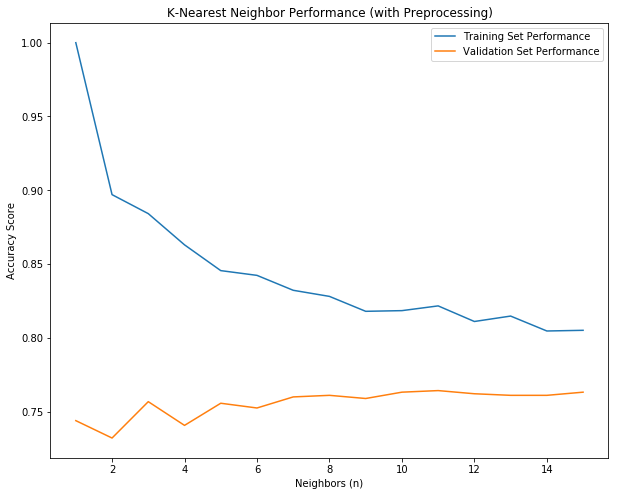

In [42]:
plt.figure(figsize = (10, 8))
max_n = 15
neighbors = np.arange(1, max_n+1)
train_scores = np.empty(len(neighbors))
val_scores = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn_tmp = KNeighborsClassifier(n_neighbors = k)
    knn_tmp.fit(X_train, y_train)
    train_scores[i] = knn_tmp.score(X_train, y_train)
    val_scores[i] = knn_tmp.score(X_val, y_val)

plt.plot(neighbors, train_scores, label = 'Training Set Performance')
plt.plot(neighbors, val_scores, label = 'Validation Set Performance')
plt.legend(loc='upper right')
plt.xlabel('Neighbors (n)')
plt.ylabel('Accuracy Score')
plt.title('K-Nearest Neighbor Performance (with Preprocessing)');

In [43]:
best_val_score = max(val_scores)
best_k = neighbors[np.where(val_scores == best_val_score)]
print('K-Nearest Neighbor Model Results (with Preprocessing):\n')
print('Best Valdition Set Performance: %3.2f' %best_val_score)
print('Optimal Number of Neighbors: %d' % best_k[0])

K-Nearest Neighbor Model Results (with Preprocessing):

Best Valdition Set Performance: 0.76
Optimal Number of Neighbors: 11


The results shown above do indeed indicate that the ```KNeighborsClassifer``` does indeed perform better as a result of the data processing, and that it performs best on the validation set using 11 neighbors. Using combining the use of data processing along with the optimal number of neighbors, we can now see how a more finely tuned ```KNeighborsClassifer``` performs on the test dataset. 

In [44]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
give_metrics(y_test, predictions, 3)

Performance Metrics: 

Confusion Matrix:
[[5440 1405  522]
 [ 203  780  155]
 [   4    8   92]]


Class 0:
Recall:  0.7384281254241889
Precision:  0.963343368160085
F1 Score: 0.8360227447364378


Class 1:
Recall:  0.6854130052724078
Precision:  0.35567715458276333
F1 Score: 0.4683278294806364


Class 2:
Recall:  0.8846153846153846
Precision:  0.11963589076723016
F1 Score: 0.21076746849942726


Overall Metrics:
Total Accuracy:  0.7331862004878615
Average Recall (Macro):  0.7694855051039937
Average Precision (Macro) : 0.47955213783669287
Average F1 Score (Macro):  0.5908683714898908


In [45]:
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#X_train = pipeline.transform(X_train)
#X_val = pipeline.transform(X_val)
#X_test = pipeline.transform(X_test)
#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_std_scaler=True, \
                                                              do_pca=11, do_smote = True)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print('Validation Set Score: ', knn.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.7846257756764743


Performance Metrics: 

Confusion Matrix:
[[5750 1417  200]
 [ 170  941   27]
 [   2   17   85]]


Class 0:
Recall:  0.7805076693362292
Precision:  0.9709557581898007
F1 Score: 0.8653773797877945


Class 1:
Recall:  0.8268892794376098
Precision:  0.39621052631578946
F1 Score: 0.5357244520352974


Class 2:
Recall:  0.8173076923076923
Precision:  0.2724358974358974
F1 Score: 0.40865384615384615


Overall Metrics:
Total Accuracy:  0.787083284934371
Average Recall (Macro):  0.8082348803605104
Average Precision (Macro) : 0.5465340606471626
Average F1 Score (Macro):  0.6521080868469682


In [46]:
tmp = []
for i in range(0, 13):
    subset = df_us[df_us['num_hours']==i]
    y = subset['class'].values
    X = subset.drop(columns=cols_to_drop).values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    scaler = StandardScaler()
    pca = PCA()
    pipeline = make_pipeline(scaler, pca)
    pipeline.fit(X_train)
    
    best_n = 0
    total = 0
    for percent in pca.explained_variance_ratio_:
        total += percent
        best_n += 1
        if total >= 0.95:
            break
    
    #scaler = StandardScaler()
    #pca = PCA(n_components=best_n)
    #pipeline = make_pipeline(scaler, pca)
    #X_transform = pipeline.fit_transform(X)
    #X_train, X_val, y_train, y_val = train_test_split(X_transform, y, test_size=0.3, random_state=rs)
    
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=i, do_std_scaler=True, \
                                                                  do_pca=best_n)
    
    max_n = 15
    neighbors = np.arange(1, max_n+1)
    train_scores = np.empty(len(neighbors))
    val_scores = np.empty(len(neighbors))
    for j, k in enumerate(neighbors):
        knn_tmp = KNeighborsClassifier(n_neighbors = k)
        knn_tmp.fit(X_train, y_train)
        train_scores[j] = knn_tmp.score(X_train, y_train)
        val_scores[j] = knn_tmp.score(X_val, y_val)
    best_val_score = max(val_scores)
    best_train_score = max(train_scores)
   
    tmp.append([i, best_train_score, best_val_score])
    
tmp = np.asarray(tmp)
KNN_performances_df = pd.DataFrame({'num_hours': tmp[:,0], 'best_train_performance': tmp[:,1],\
                                        'best_val_performance': tmp[:,2]})


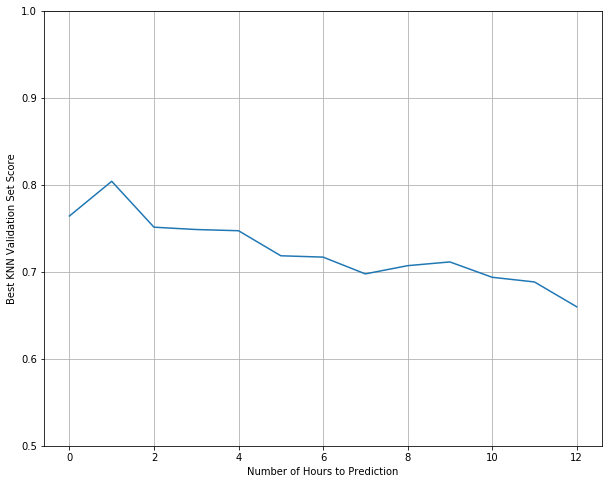

In [47]:
plt.figure(figsize = (10, 8))
plt.plot(KNN_performances_df.num_hours, KNN_performances_df.best_val_performance)
plt.ylim([0.5, 1])
plt.grid()
plt.xlabel('Number of Hours to Prediction')
plt.ylabel('Best KNN Validation Set Score');

### 3.4: Random Forest Analysis

In [48]:
#y = df_us[df_us['num_hours']==0]['class'].values
#X = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_us, num_hours=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Out of the box Random Forest Classifier Performance: ')
print('Validation Set Score: {}'.format(rfc.score(X_val, y_val)))
print('\n')
give_metrics(y_test, predictions, 3)

Out of the box Random Forest Classifier Performance: 
Validation Set Score: 0.8177920685959271


Performance Metrics: 

Confusion Matrix:
[[5650 1318  399]
 [ 262  830   46]
 [   2    1  101]]


Class 0:
Recall:  0.7669336229129904
Precision:  0.9553601623266824
F1 Score: 0.8508395452149687


Class 1:
Recall:  0.7293497363796133
Precision:  0.3862261516984644
F1 Score: 0.5050197748707028


Class 2:
Recall:  0.9711538461538461
Precision:  0.184981684981685
F1 Score: 0.31076923076923085


Overall Metrics:
Total Accuracy:  0.764432570565687
Average Recall (Macro):  0.82247906848215
Average Precision (Macro) : 0.5088559996689439
Average F1 Score (Macro):  0.628727385932221


/anaconda3/envs/datatools/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, num_hours=0, do_smote = True)

rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Validation Set Score: ', rfc.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.870361771286251


Performance Metrics: 

Confusion Matrix:
[[6626  660   81]
 [ 363  760   15]
 [  22    5   77]]


Class 0:
Recall:  0.8994163160038008
Precision:  0.9450862929681928
F1 Score: 0.9216859090276812


Class 1:
Recall:  0.6678383128295254
Precision:  0.5333333333333333
F1 Score: 0.593055013655872


Class 2:
Recall:  0.7403846153846154
Precision:  0.44508670520231214
F1 Score: 0.555956678700361


Overall Metrics:
Total Accuracy:  0.8668834940178882
Average Recall (Macro):  0.7692130814059807
Average Precision (Macro) : 0.6411687771679461
Average F1 Score (Macro):  0.6993785516857723


In [50]:
param_grid = {
    'max_depth': [2, 10, 100],
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': np.arange(2, 6),
    'min_samples_split': np.arange(2, 6)
}


gscv = RandomizedSearchCV(rfc, param_grid, cv=3, scoring='precision_macro')
gscv.fit(X_train, y_train)

print(gscv.best_params_)

{'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 100}


In [51]:
rfc = RandomForestClassifier(max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=50)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print('Validation Set Score: ', rfc.score(X_val, y_val))
print('\n')
give_metrics(y_test, predictions, 3)

Validation Set Score:  0.8656760521761155


Performance Metrics: 

Confusion Matrix:
[[6534  739   94]
 [ 275  846   17]
 [  16    2   86]]


Class 0:
Recall:  0.8869281932944211
Precision:  0.9573626373626374
F1 Score: 0.9208004509582863


Class 1:
Recall:  0.7434094903339191
Precision:  0.5330812854442344
F1 Score: 0.6209174311926604


Class 2:
Recall:  0.8269230769230769
Precision:  0.4365482233502538
F1 Score: 0.5714285714285714


Overall Metrics:
Total Accuracy:  0.8672319665466373
Average Recall (Macro):  0.8190869201838057
Average Precision (Macro) : 0.6423307153857085
Average F1 Score (Macro):  0.7200196228639459


In [52]:
feature_importances = pd.DataFrame(rfc.feature_importances_, \
                                   index = df_us[df_us['num_hours']==0].drop(columns=cols_to_drop).columns, \
                                   columns=['importance']).sort_values('importance', ascending=False)

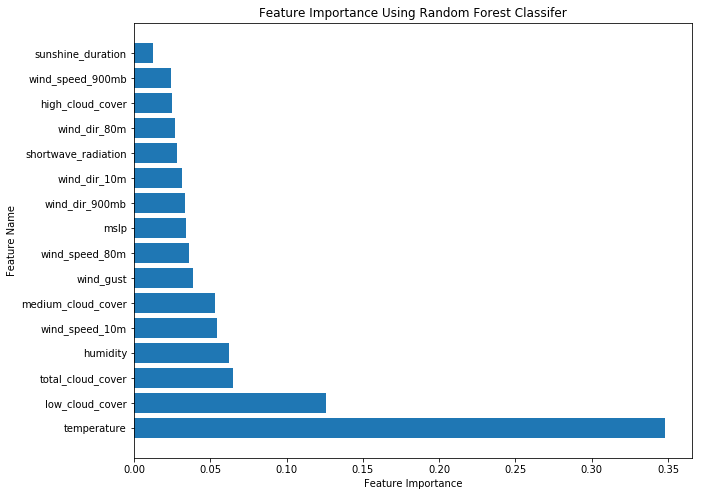

In [53]:
plt.figure(figsize=(10,8))
plt.barh(feature_importances.index, feature_importances.importance.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance Using Random Forest Classifer');

## Section 4: In-Depth Analysis - Building Nueral Networks

### 4.1: Analysis of Precision and F1 Score as Loss Functions

In [54]:
def R(tp, fn):
    '''Given the number of true positives, return the recall.
    Number of false negatives is defined outside the function as a constant. 
    '''
    return tp / (tp + fn)
def P(tp, fp):
    '''Given the number of true positives, return the precision.
    Number of flase positives is defined outside the function as a constant.
    '''
    return tp / (tp + fp)
def F1(tp, fp, fn):
    '''Given the number of true positives, return the precision.
    Number of flase negatives and false positives are defined outside the function as constants
    '''
    return 2 * (R(tp, fn) * P(tp, fp) / (R(tp, fn) + P(tp, fp)))

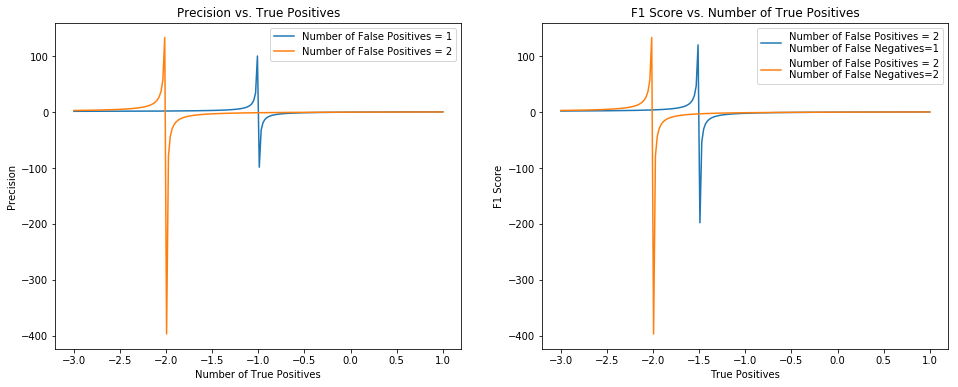

In [55]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
tp = np.linspace(-3, 1, 200)
fp = 1
y_P = P(tp, fp) 
plt.plot(tp, y_P, label='Number of False Positives = 1')
tp = np.linspace(-3, 1, 200)
fp = 2
y_P = P(tp, fp) 
plt.plot(tp, y_P, label='Number of False Positives = 2')
plt.xlabel('Number of True Positives')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision vs. True Positives')

plt.subplot(1, 2, 2)
fn = 1
y_F1 = F1(tp, fp, fn)
plt.plot(tp, y_F1, label='Number of False Positives = 2\nNumber of False Negatives=1')
fn= 2
y_F1 = F1(tp, fp, fn)
plt.plot(tp, y_F1, label='Number of False Positives = 2\nNumber of False Negatives=2')
plt.title('F1 Score vs. Number of True Positives')
plt.xlabel('True Positives')
plt.legend()
plt.ylabel('F1 Score');

### 4.2: Fine Tuning the Nueral Networks

In [56]:
#X = df[df['num_hours']==0].drop(columns=cols_to_drop).values
#y = df[df['num_hours']==0]['class'].values.reshape(-1,)
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)

#sm = SMOTE(random_state=rs)
#X_train, y_train = sm.fit_sample(X_train, y_train)

#X_scaler = MinMaxScaler(feature_range=(0,1))
#X_train = X_scaler.fit_transform(X_train)
#X_val = X_scaler.transform(X_val)

#X_test = X_scaler.transform(df_test[df_test['num_hours']==0].drop(columns=cols_to_drop).values)
#y_test = df_test[df_test['num_hours']==0]['class'].values.reshape(-1,)

X_train, X_val, X_test, y_train, y_val, y_test = \
prepare_data(df, num_hours=0, do_min_max_scaler = True, do_smote = True)

In [57]:
# define structure of model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(16, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [58]:
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 141207 samples, validate on 23689 samples
Epoch 1/10
141207/141207 [==============================] - 5s 32us/step - loss: 0.3935 - acc: 0.8402 - val_loss: 0.4486 - val_acc: 0.7937
Epoch 2/10
141207/141207 [==============================] - 4s 30us/step - loss: 0.3290 - acc: 0.8669 - val_loss: 0.4930 - val_acc: 0.7639
Epoch 3/10
141207/141207 [==============================] - 4s 30us/step - loss: 0.3120 - acc: 0.8750 - val_loss: 0.4665 - val_acc: 0.7850
Epoch 4/10
141207/141207 [==============================] - 4s 30us/step - loss: 0.2998 - acc: 0.8800 - val_loss: 0.4101 - val_acc: 0.8066
Epoch 5/10
141207/141207 [==============================] - 4s 31us/step - loss: 0.2912 - acc: 0.8833 - val_loss: 0.5262 - val_acc: 0.7665
Epoch 6/10
141207/141207 [==============================] - 4s 30us/step - loss: 0.2831 - acc: 0.8875 - val_loss: 0.4720 - val_acc: 0.7813
Epoch 7/10
141207/141207 [==============================] - 4s 31us

In [59]:
predictions = model.predict(X_test)
give_metrics(y_test, np.argmax(predictions, axis=1), 3)

Performance Metrics: 

Confusion Matrix:
[[6155 1036  176]
 [ 216  872   50]
 [  16    0   88]]


Class 0:
Recall:  0.8354825573503462
Precision:  0.9636762173164239
F1 Score: 0.8950123600407154


Class 1:
Recall:  0.7662565905096661
Precision:  0.4570230607966457
F1 Score: 0.572554169402495


Class 2:
Recall:  0.8461538461538461
Precision:  0.2802547770700637
F1 Score: 0.42105263157894735


Overall Metrics:
Total Accuracy:  0.8264606806830062
Average Recall (Macro):  0.8159643313379528
Average Precision (Macro) : 0.5669846850610444
Average F1 Score (Macro):  0.6690619450734948


In [60]:
X_train, X_val, X_test, y_train, y_val, y_test = \
prepare_data(df, num_hours=0, do_min_max_scaler = True)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=class_weights, epochs=10, verbose=True)

Train on 55272 samples, validate on 23689 samples
Epoch 1/10
55272/55272 [==============================] - 2s 32us/step - loss: 0.2501 - acc: 0.8855 - val_loss: 0.2697 - val_acc: 0.8829
Epoch 2/10
55272/55272 [==============================] - 2s 33us/step - loss: 0.2481 - acc: 0.8859 - val_loss: 0.2712 - val_acc: 0.8767
Epoch 3/10
55272/55272 [==============================] - 2s 33us/step - loss: 0.2480 - acc: 0.8867 - val_loss: 0.2648 - val_acc: 0.8831
Epoch 4/10
55272/55272 [==============================] - 2s 33us/step - loss: 0.2460 - acc: 0.8878 - val_loss: 0.2664 - val_acc: 0.8853
Epoch 5/10
55272/55272 [==============================] - 2s 33us/step - loss: 0.2463 - acc: 0.8876 - val_loss: 0.2741 - val_acc: 0.8796
Epoch 6/10
55272/55272 [==============================] - 2s 32us/step - loss: 0.2443 - acc: 0.8890 - val_loss: 0.2605 - val_acc: 0.8855
Epoch 7/10
55272/55272 [==============================] - 2s 32us/step - loss: 0.2436 - acc: 0.8878 - val_loss: 0.2632 - val_acc

In [61]:
predictions = model.predict(X_test)
give_metrics(y_test, np.argmax(predictions, axis=1), 3)

Performance Metrics: 

Confusion Matrix:
[[7116  241   10]
 [ 664  473    1]
 [  71    6   27]]


Class 0:
Recall:  0.9659291434776707
Precision:  0.9063813526939244
F1 Score: 0.9352083059534763


Class 1:
Recall:  0.4156414762741652
Precision:  0.6569444444444444
F1 Score: 0.5091496232508074


Class 2:
Recall:  0.25961538461538464
Precision:  0.7105263157894737
F1 Score: 0.38028169014084506


Overall Metrics:
Total Accuracy:  0.8846555929840865
Average Recall (Macro):  0.5470620014557401
Average Precision (Macro) : 0.7579507043092809
Average F1 Score (Macro):  0.6354666548034111


In [62]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(16, )))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tmp = []
for i in range(13):
    #subset = df[df['num_hours']==i]
    #y = subset['class'].values.reshape(-1, )
    #X = subset.drop(columns=cols_to_drop)
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    
    #X_scaler = MinMaxScaler(feature_range=(0,1))
    #X_train = X_scaler.fit_transform(X_train)
    #X_val = X_scaler.transform(X_val)
    X_train, X_val, X_test, y_train, y_val, y_test = \
    prepare_data(df, num_hours=i, do_min_max_scaler = True)
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=class_weights, epochs=5, verbose=False);
    
    train_loss = model.evaluate(X_train, y_train)[0]
    train_cat_acc = model.evaluate(X_train, y_train)[1]
    
    val_loss = model.evaluate(X_val, y_val)[0]
    val_cat_acc = model.evaluate(X_val, y_val)[1]
    
    tmp.append([i, train_loss, train_cat_acc, val_loss, val_cat_acc])

NN_model_performances = pd.DataFrame(tmp)
NN_model_performances.columns = ['num_hours', 'train_loss', 'train_cat_acc', 'val_loss', 'val_cat_acc']

23668/23668 [==============================] - 0s 12us/step


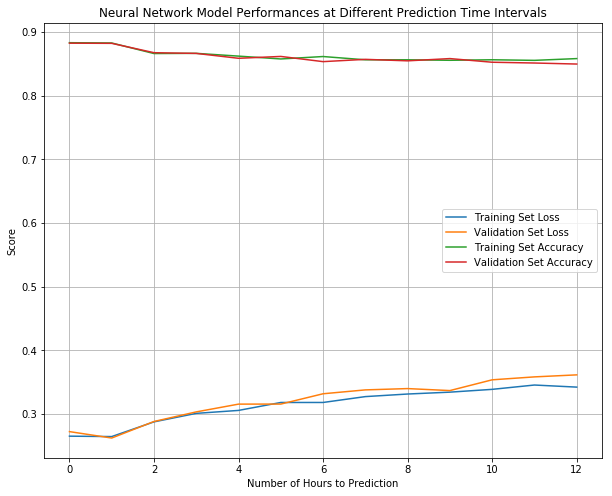

In [63]:
plt.figure(figsize = (10, 8))
plt.plot(NN_model_performances.num_hours, NN_model_performances.train_loss, label='Training Set Loss')
plt.plot(NN_model_performances.num_hours, NN_model_performances.val_loss, label='Validation Set Loss')
plt.plot(NN_model_performances.num_hours, NN_model_performances.train_cat_acc, label='Training Set Accuracy')
plt.plot(NN_model_performances.num_hours, NN_model_performances.val_cat_acc, label='Validation Set Accuracy')
plt.grid()
plt.legend(loc='center right')
plt.xlabel('Number of Hours to Prediction')
plt.ylabel('Score')

plt.title('Neural Network Model Performances at Different Prediction Time Intervals');

In [ ]:
num_hidden_layer_options = [1, 2, 3]
num_nodes_options = [50, 100, 200]
max_epochs = 12
patience = 3
num_inputs = 16
learning_rate = 0.001

tmp = []

for i in range(0, 13):
    subset = df[df['num_hours']==i]
    y = subset['class'].values.reshape(-1, )
    X = subset.drop(columns=cols_to_drop)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
    
    X_test = df_test[df_test['num_hours']==i].drop(columns=cols_to_drop).values
    y_test = df_test[df_test['num_hours']==i]['class'].values.reshape(-1, )
    
    X_scaler = MinMaxScaler(feature_range=(0,1))
    X_train = X_scaler.fit_transform(X_train)
    X_val = X_scaler.transform(X_val)
    X_test = X_scaler.transform(X_test)
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

    for num_nodes in num_nodes_options:
    
        for j in range(len(num_hidden_layer_options)):
            model = Sequential()
            model.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))  
            
            for k in range(num_hidden_layer_options[j]-1):
                model.add(Dense(num_nodes, activation='relu'))
        
            model.add(Dense(3, activation='softmax'))
            adam = keras.optimizers.Adam(learning_rate)
            model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', \
                          metrics=['accuracy', categorical_accuracy])
            early_stopping_monitor = EarlyStopping(patience=patience)
            model_hist = model.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val),\
                                   class_weight=class_weights, callbacks=[early_stopping_monitor], verbose=0)
        
            epochs = early_stopping_monitor.stopped_epoch
        
            loss = model_hist.history['loss'][-1]
            val_loss = model_hist.history['val_loss'][-1]
        
            acc = model_hist.history['acc'][-1]
            val_acc = model_hist.history['val_acc'][-1]
            predictions = model.predict(X_test)
            test_acc, test_R_avg, test_P_avg, test_F1_avg = \
            give_metrics(y_test, np.argmax(predictions, axis=1), 3, True) 
            
         
            tmp.append([i, num_nodes, num_hidden_layer_options[j], epochs, loss, val_loss, acc, \
                        val_acc, test_acc, test_R_avg, test_P_avg, test_F1_avg])
        

NN_model_tuning = pd.DataFrame(tmp)
NN_model_tuning.columns = ['num_hours', 'num_nodes', 'num_hidden_layers', 'epochs', 'loss', 'val_loss', 'acc', \
                           'val_acc', 'test_acc', 'test_recall_avg', 'test_precision_avg', 'test_F1_avg']

In [ ]:
NN_model_tuning

In [ ]:
tmp = []
for i in range(0, 13):
    subset = NN_model_tuning[NN_model_tuning['num_hours,']==i]
    tmp.append(subset.loc[subset['test_F1_avg'].idxmax()])
best_NN_models = pd.DataFrame(tmp)
best_NN_models = best_NN_models.reset_index(drop=True)
best_NN_models

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(best_NN_models.num_hours, best_NN_models.test_acc, label='Test Set Accuracy')
plt.plot(best_NN_models.num_hours, best_NN_models.test_recall_avg, label='Test Set Average Recall (Macro)')
plt.plot(best_NN_models.num_hours, best_NN_models.test_precision_avg, label='Test Set Average Precision (Macro)')
plt.plot(best_NN_models.num_hours, best_NN_models.test_F1_avg, label='Test Set Average F1 Score (Macro)')
plt.title('Tuned Neural Network Performances')
plt.ylabel('Score')
plt.xlabel('Number of Hours to Prediction')
plt.axis([-0.5, 12.5, 0,1])
plt.legend()
plt.show()

### 4.3: Building a System of Neural Networks to Make Predictions

In [ ]:
best_model_structures = best_NN_models[['num_hours', 'num_nodes', 'num_hidden_layers', 'epochs']].astype(int)
best_model_structures

In [ ]:
i = 0
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_0hr = Sequential()
model_0hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_0hr.add(Dense(num_nodes, activation='relu'))
model_0hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_0hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_0hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)


In [ ]:
i = 1
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_1hr = Sequential()
model_1hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_1hr.add(Dense(num_nodes, activation='relu'))
model_1hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_1hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_1hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 2
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_2hr = Sequential()
model_2hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_2hr.add(Dense(num_nodes, activation='relu'))
model_2hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_2hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_2hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), 
              class_weight=class_weights, verbose=0)

In [ ]:
i = 3
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_3hr = Sequential()
model_3hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_3hr.add(Dense(num_nodes, activation='relu'))
model_3hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_3hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_3hr.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 4
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_4hr = Sequential()
model_4hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_4hr.add(Dense(num_nodes, activation='relu'))
model_4hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_4hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_4hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 5
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_5hr = Sequential()
model_5hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_5hr.add(Dense(num_nodes, activation='relu'))
model_5hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_5hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_5hr.fit(X_train, y_train, epochs=max_epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 6
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_6hr = Sequential()
model_6hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_6hr.add(Dense(num_nodes, activation='relu'))
model_6hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_6hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_6hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 7
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_7hr = Sequential()
model_7hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_7hr.add(Dense(num_nodes, activation='relu'))
model_7hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_7hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_7hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 8
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_8hr = Sequential()
model_8hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_8hr.add(Dense(num_nodes, activation='relu'))
model_8hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_8hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_8hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 9
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_9hr = Sequential()
model_9hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_9hr.add(Dense(num_nodes, activation='relu'))
model_9hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_9hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_9hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
              class_weight=class_weights, verbose=0)

In [ ]:
i = 10
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_10hr = Sequential()
model_10hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_10hr.add(Dense(num_nodes, activation='relu'))
model_10hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_10hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_10hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
               class_weight=class_weights, verbose=0)

In [ ]:
i = 11
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_11hr = Sequential()
model_11hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_11hr.add(Dense(num_nodes, activation='relu'))
model_11hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_11hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_11hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
               class_weight=class_weights, verbose=0)

In [ ]:
i = 12
num_hours = best_model_structures.iloc[i][0]
num_nodes = best_model_structures.iloc[i][1]
epochs = best_model_structures.iloc[i][3]
learning_rate = 0.001

subset = df[df['num_hours']==num_hours]
y = subset['class'].values.reshape(-1, )
X = subset.drop(columns=cols_to_drop)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=rs)
X_scaler = MinMaxScaler(feature_range=(0,1))
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model_12hr = Sequential()
model_12hr.add(Dense(num_nodes, activation='relu', input_shape=(num_inputs, )))
for j in range(1, best_model_structures.iloc[i][2]):
    model_12hr.add(Dense(num_nodes, activation='relu'))
model_12hr.add(Dense(3, activation='softmax'))
adam = keras.optimizers.Adam(learning_rate)
model_12hr.compile(optimizer=adam, loss='sparse_categorical_crossentropy')
model_12hr.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val), \
               class_weight=class_weights, verbose=0)

In [ ]:
sample_prediction = (np.array([[45.0, 83, 1029.3, 55, 25, 30, 0, 20, 0, 9.7, \
                               257.50, 18.20, 271.73, 16.85, 268.97, 17.24]])).reshape(16,)
make_weather_prediction(sample_prediction)
